In [ ]:
# default_exp embedding

In [5]:
#!pip install fair-esm

In [4]:
# export
import torch
import esm

In [19]:
# export
# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()

KeyboardInterrupt: 

In [20]:
model = model.to("cuda")

In [21]:
model

ProteinBertModel(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (self_attn_layer_norm): ESM1bLayerNorm(torch.Size([1280]), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): ESM1bLayerNorm(torch.Size([1280]), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=12

# Example from repo

In [7]:
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
]

In [16]:
from tqdm.notebook import tqdm

In [23]:
# export
def getSequenceRepresentation(Data):
    batch_labels, batch_strs, batch_tokens = batch_converter(Data)
    batch_tokens = batch_tokens.to("cuda")
    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]

    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, (_, seq) in tqdm(enumerate(Data)):
        sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    return sequence_representations, results

In [24]:
seuence_represntations, results = getSequenceRepresentation(data)

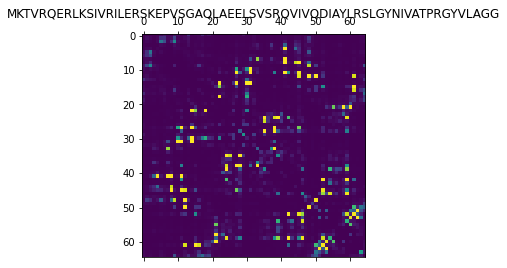

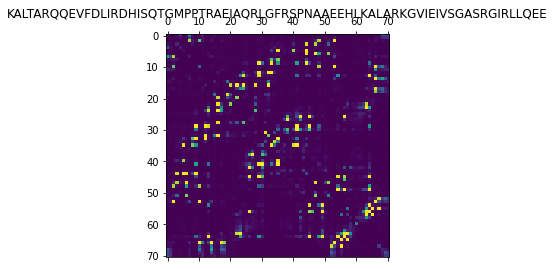

In [26]:
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)].cpu())
    plt.title(seq)
    plt.show()

In [12]:
import pandas as pd
df = pd.read_csv("/ssdata/clinvar/clinvar/missenseVariants.csv")

In [37]:
df

,Unnamed: 0,#AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,...,PositionVCF,ReferenceAlleleVCF,AlternateAlleleVCF,variant,og,loc,newAA,match,label,sequence
0,41,15062,single nucleotide variant,NM_020779.4(WDR35):c.2590G>A (p.Ala864Thr),57539,WDR35,HGNC:29250,Likely pathogenic,1,"May 25, 2017",...,19933469,C,T,Ala864Thr,Ala,864,Thr,1.0,True,MFFYLSKKISIPNNVKLQCVSWNKEQGFIACGGEDGLLKVLKLETQ...
1,55,15069,single nucleotide variant,NM_138413.4(HOGA1):c.860G>T (p.Gly287Val),112817,HOGA1,HGNC:25155,Pathogenic/Likely pathogenic,1,"Dec 16, 2018",...,97611535,G,T,Gly287Val,Gly,287,Val,1.0,True,MLGPQVWSSVRQGLSRSLSRNVGVWASGEGKKVDIAGIYPPVTTPF...
2,61,15072,single nucleotide variant,NM_138413.4(HOGA1):c.209G>C (p.Arg70Pro),112817,HOGA1,HGNC:25155,Pathogenic,1,"Jan 28, 2020",...,97584912,G,C,Arg70Pro,Arg,70,Pro,1.0,True,MLGPQVWSSVRQGLSRSLSRNVGVWASGEGKKVDIAGIYPPVTTPF...
3,63,15073,single nucleotide variant,NM_138413.4(HOGA1):c.769T>G (p.Cys257Gly),112817,HOGA1,HGNC:25155,Pathogenic/Likely pathogenic,1,"Sep 21, 2020",...,97601925,T,G,Cys257Gly,Cys,257,Gly,1.0,True,MLGPQVWSSVRQGLSRSLSRNVGVWASGEGKKVDIAGIYPPVTTPF...
4,104,15094,single nucleotide variant,NM_001194998.2(CEP152):c.794A>C (p.Gln265Pro),22995,CEP152,HGNC:29298,Pathogenic/Likely pathogenic,1,"Oct 31, 2018",...,48793359,T,G,Gln265Pro,Gln,265,Pro,1.0,True,MSLDFGSVALPVQNEDEEYDEEDYEREKELQQLLTDLPHDMLDDDL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67687,2018786,1166675,single nucleotide variant,NM_003072.5(SMARCA4):c.2738C>T (p.Pro913Leu),6597,SMARCA4,HGNC:11100,Likely pathogenic,1,"Jun 10, 2021",...,11021846,C,T,Pro913Leu,Pro,913,Leu,1.0,True,MSTPDPPLGGTPRPGPSPGPGPSPGAMLGPSPGPSPGSAHSMMGPS...
67688,2018788,1166676,single nucleotide variant,NM_003072.5(SMARCA4):c.3275T>G (p.Leu1092Arg),6597,SMARCA4,HGNC:11100,Likely pathogenic,1,"Jun 10, 2021",...,11027843,T,G,Leu1092Arg,Leu,1092,Arg,1.0,True,MSTPDPPLGGTPRPGPSPGPGPSPGAMLGPSPGPSPGSAHSMMGPS...
67689,2018794,1166679,single nucleotide variant,NM_002397.5(MEF2C):c.17T>A (p.Ile6Asn),4208,MEF2C,HGNC:6996,Likely pathogenic,1,"May 28, 2021",...,88823772,A,T,Ile6Asn,Ile,6,Asn,1.0,True,MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...
67690,2018804,1166684,single nucleotide variant,NM_000834.5(GRIN2B):c.1971G>C (p.Glu657Asp),2904,GRIN2B,HGNC:4586,Likely pathogenic,1,"May 28, 2021",...,13608642,C,G,Glu657Asp,Glu,657,Asp,1.0,True,MKPRAECCSPKFWLVLAVLAVSGSRARSQKSPPSIGIAVILVGTSD...


In [45]:
def prepSeq(row):
    s = row["sequence"]
    loc = int(row["loc"]) - 1
    sPrime = s[max(0, loc-512) : min(len(s), loc + 512)]
    return sPrime

In [46]:
seqs = list(zip(df.index, [prepSeq(r) for i,r in tqdm(df.iterrows())]))

In [51]:
missenseSeuence_represntations, missenseResults = getSequenceRepresentation(seqs[:10])

ValueError: Sequence length 1173 above maximum  sequence length of 1024

In [49]:
missenseSeuence_represntations

[tensor([ 0.0058,  0.3613,  0.0860,  ..., -0.0148, -0.0614,  0.0825],
        device='cuda:0')]